In [24]:
import pdb
import numpy as np
import gcp.bigquery as bq
import gcp.storage as storage
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt

try:
   import cPickle as pickle
except:
   import pickle
EST_PICKLE_FILENAME = 'final_estimator.pkl'

seed = 13
np.random.seed(seed)

In [25]:

# Put all categorical data first for easier implementation of One Hot Encoding.
fields_str = """
gap	day_in_week	weather_1_slots_ago	weather_2_slots_ago	weather_3_slots_ago	busy_time	
tj_level1_1_slots_ago	tj_level2_1_slots_ago	tj_level3_1_slots_ago	tj_level4_1_slots_ago	
tj_level1_2_slots_ago	tj_level2_2_slots_ago	tj_level3_2_slots_ago	tj_level4_2_slots_ago	
tj_level1_3_slots_ago	tj_level2_3_slots_ago	tj_level3_3_slots_ago	tj_level4_3_slots_ago	
temperature_1_slots_ago	pm25_1_slots_ago	
temperature_2_slots_ago	pm25_2_slots_ago	
temperature_3_slots_ago	pm25_3_slots_ago	
gap_1_slots_ago	sum_price_1_slots_ago	
gap_2_slots_ago	sum_price_2_slots_ago	
gap_3_slots_ago	sum_price_3_slots_ago	
f1	f11	f11_1	f11_2	f11_3	f11_4	f11_5	f11_6	f11_7	
f11_8	f13_4	f13_8	f14	f14_1	f14_10	f14_2	f14_3	f14_6	f14_8	f15	f15_1	
f15_2	f15_3	f15_4	f15_6	f15_7	f15_8	f16	f16_1	f16_10	f16_11	f16_12	f16_3	
f16_4	f16_6	f17	f17_2	f17_3	f17_4	f17_5	f19	f19_1	f19_2	f19_3	f19_4	f1_1	
f1_10	f1_11	f1_2	f1_3	f1_4	f1_5	f1_6	f1_7	f1_8	f20	f20_1	f20_2	
f20_4	f20_5	f20_6	f20_7	f20_8	f20_9	f21_1	f21_2	f22	f22_1	f22_2	f22_3	
f22_4	f22_5	f23	f23_1	f23_2	f23_3	f23_4	f23_5	f23_6	f24	f24_1	f24_2	f24_3	
f25	f25_1	f25_3	f25_7	f25_8	f25_9	f2_1	f2_10	f2_11	f2_12	f2_13	f2_2	
f2_4	f2_5	f2_6	f2_7	f2_8	f3_1	f3_2	f3_3	f4	f4_1	f4_10	f4_11	
f4_13	f4_14	f4_16	f4_17	f4_18	f4_2	f4_3	f4_5	f4_6	f4_7	f4_8	f4_9	
f5	f5_1	f5_3	f5_4	f6	f6_1	f6_2	f6_4	f7	f8	f8_1	f8_2	f8_3	f8_4	
f8_5
"""
fields = map(lambda x: x.strip(), fields_str.split('\t'))
features = fields[1:]

# Use this instead of len(features) since this variable can change
# e.g. when one hot encoding is used and/or new features are added.
n_features = len(features)

# Scorer Creation (MAPE)

In [9]:
def mape(y, predictions):
#   num_timeslots = 43
#   num_districts = 66
  if len(y.shape) == 1:
    y = np.asmatrix(y)
  if len(predictions.shape) == 1:
    predictions = np.asmatrix(predictions)
  y = y.astype(float)
  predictions = predictions.astype(float)
  return np.mean(np.absolute((y-predictions)/y))

# from keras import backend as K

# def mape(y, predictions):
#   return K.mean(K.abs(y-predictions/K.clip(K.abs(y), K.epsilon(), np.inf)), axis=-1)

mape_scorer = make_scorer(mape, greater_is_better=False)

# Feature Selection

In [21]:
%%sql --module q_all

SELECT *, HASH(CAST(district_id AS STRING) +timeslot) AS hash_value,
  IF(ABS(HASH(CAST(district_id AS STRING) + timeslot)) % 2 == 1, 'True', 'False')
    AS included_in_sample, IF(timeofday_slot >= 50 AND timeofday_slot <= 53, 1, 0) AS busy_time
FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE gap > 0
LIMIT 20000

# The above query randomizes its outputs.

In [12]:
query = bq.Query(q_all)

tableresult = query.results()

all_data = np.zeros((tableresult.length, len(fields)))
print 'there are {} rows'.format(tableresult.length)
for rcounter, row in enumerate(tableresult):
  for fcounter, field in enumerate(fields):
    all_data[rcounter, fcounter] = row[field]
  if rcounter % 5000 == 0:
    print 'processed {} rows'.format(rcounter)
all_data_original = np.copy(all_data)

there are 1000 rows
processed 0 rows


In [13]:
one_hot = OneHotEncoder(categorical_features=[1, 2, 3, 4], sparse=False,
                        n_values=[7, 10, 10, 10])
one_hot.fit(Imputer().fit_transform(all_data_original))
print "n_values_:"
print one_hot.n_values_
print "feature_indices_:"
print one_hot.feature_indices_
all_data = one_hot.fit_transform(Imputer().fit_transform(all_data_original))
n_features = all_data.shape[1] - 1
print 'new number of features: {}'.format(n_features)

n_values_:
[ 7 10 10 10]
feature_indices_:
[ 0  7 17 27 37]
new number of features: 196


In [14]:
# Split the data into train and test sets.
data_size = all_data.shape[0]
training_size = data_size * 80/100
indices = np.random.permutation(data_size)
training_idx, test_idx = indices[:training_size], indices[training_size:]
all_data_train, all_data_test = all_data_original[training_idx,:], all_data_original[test_idx,:]

data_train = all_data_train[:,1:]
targets_train = all_data_train[:,0]
data_test = all_data_test[:,1:]
targets_test = all_data_test[:,0]

# Building and Testing Algorithm(s)

In [30]:
steps = [
  ('impute', Imputer()),
  # Remember that gap, the first variable, was removed, thus categorical_features
  # should start at index 0.
  ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False,
                           n_values=[7, 10, 10, 10])),
  ('scale', StandardScaler()),
  ('estimate', GradientBoostingRegressor(n_estimators=n_features, learning_rate=0.5))

]

est = Pipeline(steps)

steps_bagging = [
  ('impute', Imputer()),
  # Remember that gap, the first variable, was removed, thus categorical_features
  # should start at index 0.
  ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False,
                           n_values=[7, 10, 10, 10])),
  ('scale', StandardScaler()),
  ('estimate', BaggingRegressor(
      GradientBoostingRegressor(
        n_estimators=n_features, learning_rate=0.5,
        verbose=0, warm_start=False
      )))

]

bagging_est = Pipeline(steps_bagging)

In [31]:
bagging_est.fit(data_train, targets_train)

Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], dtype=<type 'float'>,
       handle_unknown='error', n_values=[7, 10, 10, 10], sparse=False)), ('scale', StandardScaler(copy=True, with_mean=T...ax_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0))])

In [32]:
est.fit(data_train, targets_train)

Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], dtype=<type 'float'>,
       handle_unknown='error', n_values=[7, 10, 10, 10], sparse=False)), ('scale', StandardScaler(copy=True, with_mean=T...0.0, n_estimators=163,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))])

In [33]:
test_predictions = bagging_est.predict(data_test)
print(mape(targets_test, test_predictions))

0.674685525831


In [34]:
test_predictions = est.predict(data_test)
print(mape(targets_test, test_predictions))

0.92368326361


In [36]:
train_predictions = bagging_est.predict(data_train)
print(mape(targets_train, train_predictions))

0.28845773435


OK seems like bagging is useful indeed.

How many training data do we actually need?

working on 1
working on 2
working on 3
working on 4
working on 5
working on 6
working on 7
working on 8
working on 9


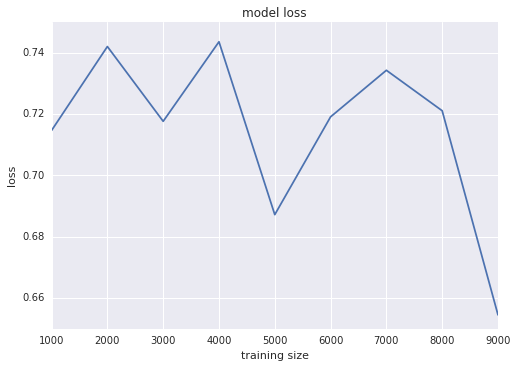

In [37]:
tsize = []
loss = []
for i in range(1, 10):
  print "working on {}".format(i)
  tsize.append(i * 1000)
  bagging_est.fit(data_train[0:i*1000], targets_train[0:i*1000])
  test_predictions = bagging_est.predict(data_test[0:i*1000])
  loss.append(mape(targets_test[0:i*1000], test_predictions))
  
plt.plot(tsize, loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('training size')
plt.show()